In [17]:
import pandas as pd
import regex as re
import numpy as np
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction.text import TfidfVectorizer
from flair.models import SequenceTagger
from flair.data import Sentence

In [18]:
df = pd.read_csv('data/clean/clean_dataset.csv')
df.head()

,name,name_length,clean_name,noun_id,en_noun,dual_noun,clean_en_noun
0,Gamis Pria Dewasa Premium / Jubah Pakistan Polos,38,gamis pria dewasa premium jubah pakistan polos,gamis pria premium jubah pakistan,gamis pria dewasa premium jubah pakistan polos,gamis pria premium jubah pakistan dewasa polos,gamis pria dewasa jubah pakistan polos
1,Buket Bunga Mawar Flanel / Bunga wisuda / Bung...,11,buket bunga mawar flanel bunga wisuda bunga so...,buket bunga mawar flanel wisuda souvenir,buket bunga,buket bunga mawar flanel wisuda souvenir,buket bunga
2,Mika Sen Depan Supra Fit New Kaca Lampu Sein D...,10,mika sen depan supra fit new kaca lampu sein d...,mika sen depan supra fit new kaca lampu sein d...,mika motor,mika sen depan supra fit new kaca lampu sein d...,mika motor
3,Blazer wanita jumbo big size stik balik / plus...,24,blazer wanita jumbo big size stik balik plus s...,blazer wanita jumbo size stik balik plus outer,blazer wanita jumbo size stik balik,blazer wanita jumbo size stik balik plus outer,blazer wanita stik balik
4,Buku Ilmu Sosial Budaya Dasar Perspektif Baru ...,69,buku ilmu sosial budaya dasar perspektif baru ...,buku ilmu sosial budaya perspektif kesadaran ani,buku ilmu sosial budaya dasar perspektif baru ...,buku ilmu sosial budaya perspektif kesadaran ani,buku ilmu sosial budaya dasar perspektif baru ...


In [19]:
df.dropna(subset=['clean_en_noun'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8060 entries, 0 to 8060
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   name           8060 non-null   object
 1   name_length    8060 non-null   int64 
 2   clean_name     8060 non-null   object
 3   noun_id        8060 non-null   object
 4   en_noun        8060 non-null   object
 5   dual_noun      8060 non-null   object
 6   clean_en_noun  8060 non-null   object
dtypes: int64(1), object(6)
memory usage: 503.8+ KB


In [20]:
# List min_df dan range klaster
min_list = [5, 10, 20, 30, 40, 50]
range_list = [range(2, 20), range(100, 120), range(500, 520), range(1000, 1020)]
results = []  # List untuk menyimpan hasil eksperimen

In [21]:
# Fungsi untuk melakukan eksperimen
def clustering_experiment(df, min_list, range_list):
    for min_df in min_list:
        print(f"Evaluating min_df={min_df}...")
        # TF-IDF Vectorization
        vectorizers = {
            'basic_preprocessing': TfidfVectorizer(max_df=0.95, min_df=min_df, stop_words='english').fit_transform(df['clean_name']),
            'stanza_id': TfidfVectorizer(max_df=0.95, min_df=min_df, stop_words='english').fit_transform(df['noun_id']),
            'stanza_en': TfidfVectorizer(max_df=0.95, min_df=min_df, stop_words='english').fit_transform(df['en_noun']),
            'stanza_multi': TfidfVectorizer(max_df=0.95, min_df=min_df, stop_words='english').fit_transform(df['dual_noun']),
            'stanza_en_v2': TfidfVectorizer(max_df=0.95, min_df=min_df, stop_words='english').fit_transform(df['clean_en_noun'])
        }

        for name, data in vectorizers.items():
            for cluster_range in range_list:
                silhouette_scores = []
                for n_clusters in cluster_range:
                    # K-Means clustering
                    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
                    labels = kmeans.fit_predict(data)
                    score = silhouette_score(data, labels)
                    silhouette_scores.append(score)
                
                # Simpan hasil eksperimen
                avg_score = sum(silhouette_scores) / len(silhouette_scores)
                results.append({
                    'model_noun': name,
                    'min_df': min_df,
                    'cluster_range': f"{cluster_range.start}-{cluster_range.stop - 1}",
                    'avg_silhouette_score': avg_score
                })

# Jalankan eksperimen
clustering_experiment(df, min_list, range_list)

Evaluating min_df=5...
Evaluating min_df=10...
Evaluating min_df=20...
Evaluating min_df=30...
Evaluating min_df=40...
Evaluating min_df=50...


In [22]:
results_df = pd.DataFrame(results)

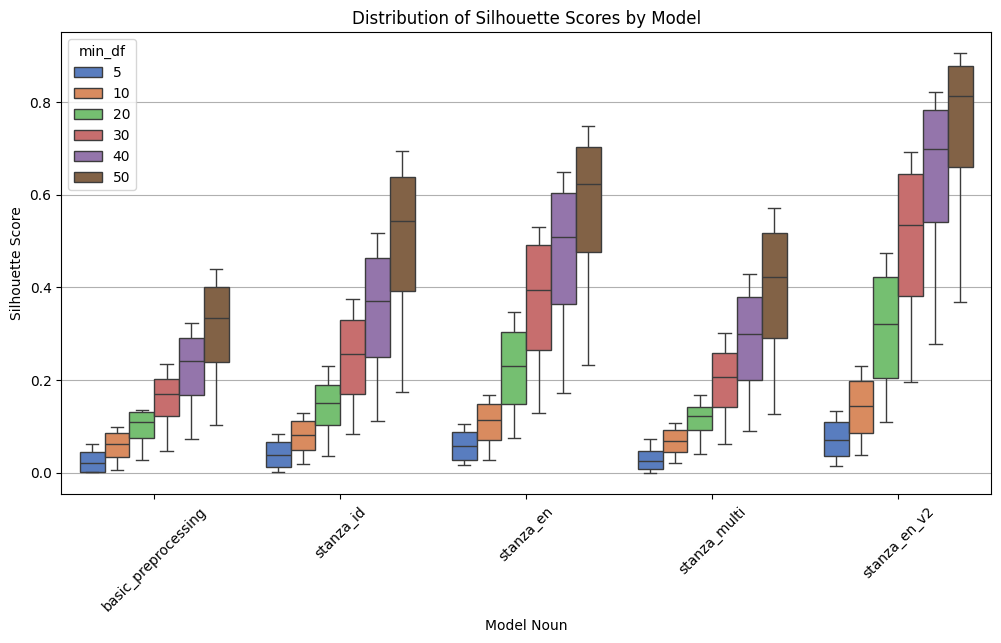

In [23]:
# Box plot
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=results_df,
    x='model_noun',
    y='avg_silhouette_score',
    palette='muted',
    hue='min_df'
)
plt.title("Distribution of Silhouette Scores by Model")
plt.xlabel("Model Noun")
plt.ylabel("Silhouette Score")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


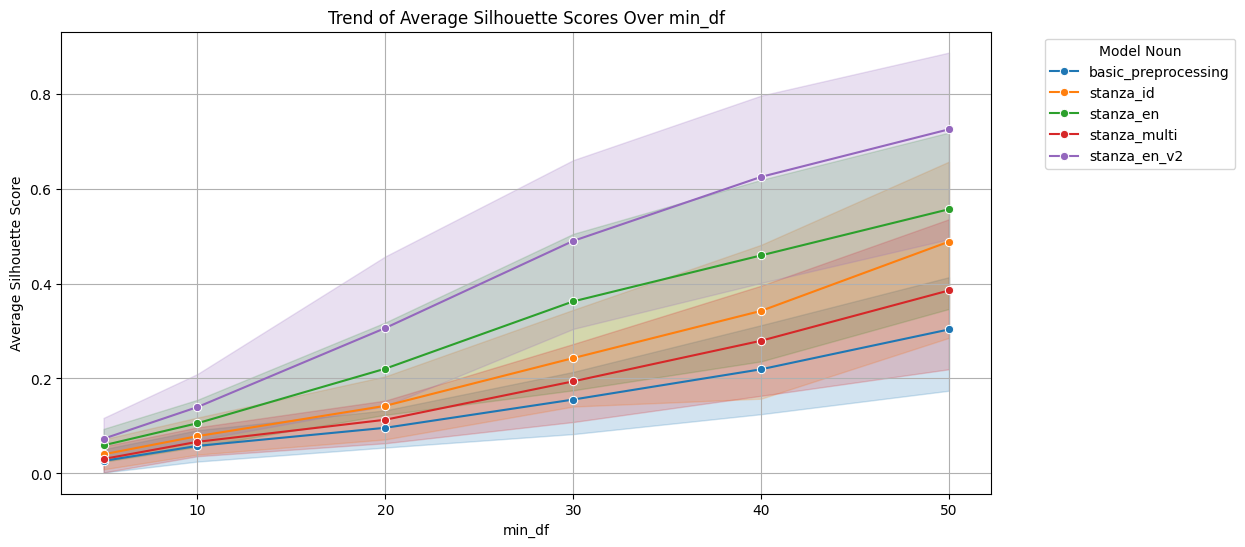

In [24]:
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=results_df,
    x='min_df',
    y='avg_silhouette_score',
    hue='model_noun',
    marker='o',
    palette='tab10'
)
plt.title("Trend of Average Silhouette Scores Over min_df")
plt.xlabel("min_df")
plt.ylabel("Average Silhouette Score")
plt.legend(title="Model Noun", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.show()


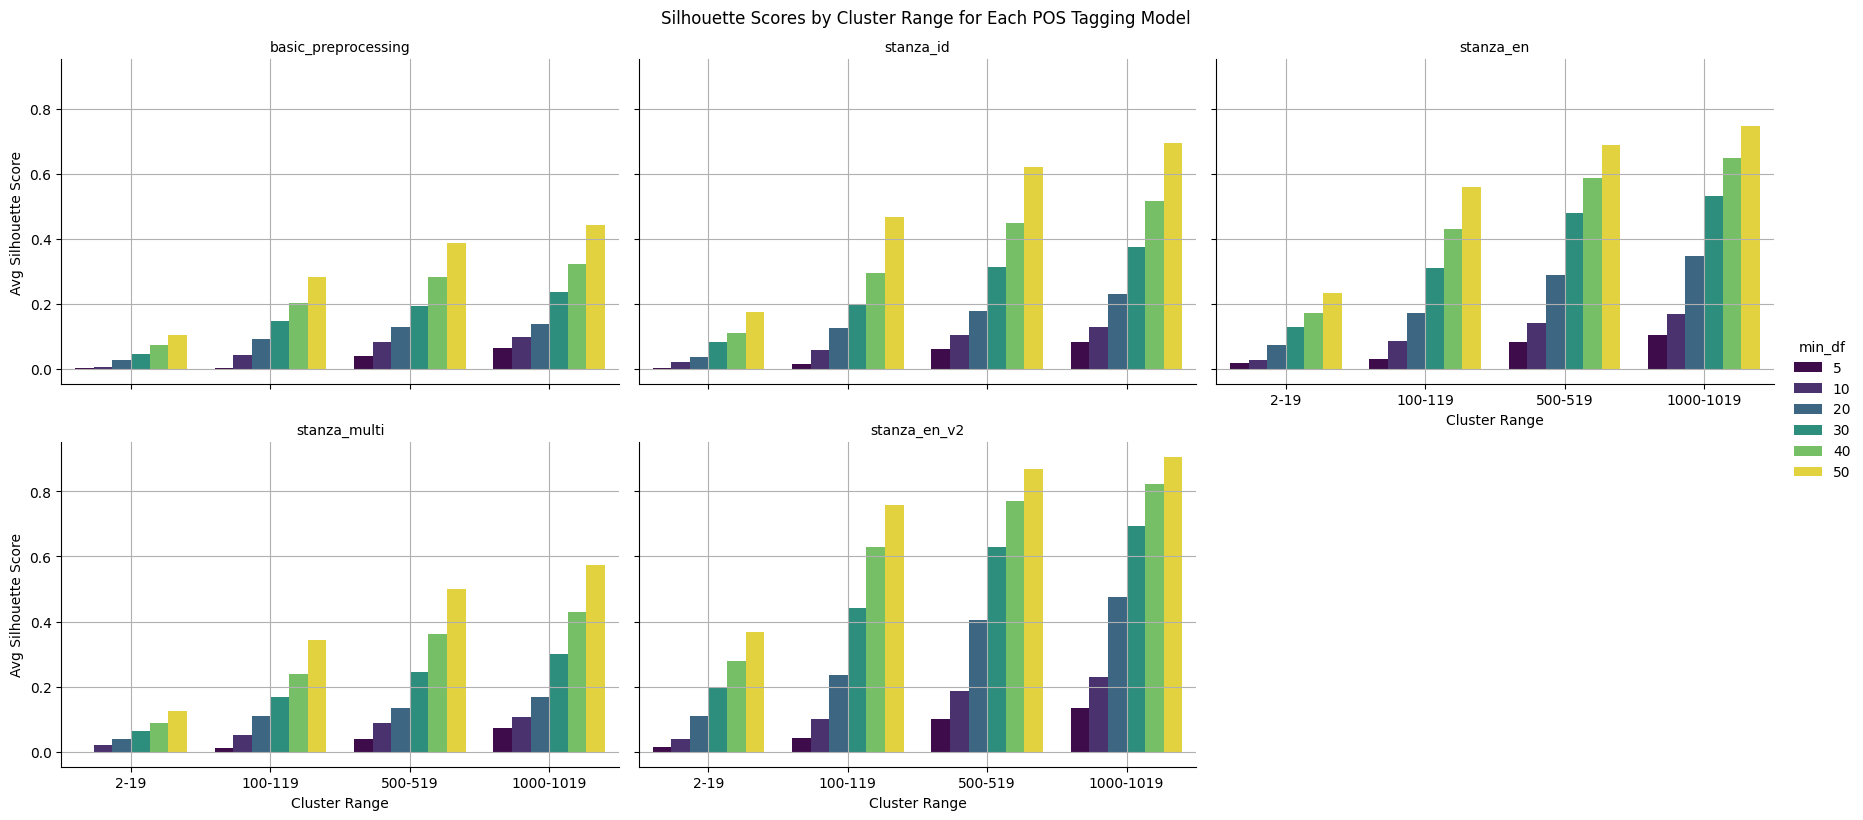

In [26]:
g = sns.FacetGrid(
    results_df,
    col="model_noun",
    col_wrap=3,
    height=4,
    aspect=1.5
)
g.map_dataframe(sns.barplot, x="cluster_range", y="avg_silhouette_score", palette="viridis", hue="min_df")
g.set_titles("{col_name}")
g.set_axis_labels("Cluster Range", "Avg Silhouette Score")
g.figure.suptitle("Silhouette Scores by Cluster Range for Each POS Tagging Model", y=1.02)
g.add_legend(title="min_df")
for ax in g.axes.flatten():
    ax.grid(True)

plt.show()